In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(10)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ 

In [2]:
cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
                            #Note, generally 0=no issue and 1-4=problem
cleveland_data<-cleveland_data|>
                    mutate(exercise_induced_angina=case_when(exercise_induced_angina==0~"No",exercise_induced_angina==1~"Yes"))|>
                    mutate(sex=case_when(sex==0~"female",sex==1~"male"))
cleveland_data

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,risk_level
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,male,4,160,286,0,2,108,Yes,1.5,2,3.0,3.0,2
67,male,4,120,229,0,2,129,Yes,2.6,2,2.0,7.0,1
37,male,3,130,250,0,0,187,No,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,male,4,130,131,0,0,115,Yes,1.2,2,1.0,7.0,3
57,female,2,130,236,0,2,174,No,0.0,2,1.0,3.0,1
38,male,3,138,175,0,0,173,No,0.0,1,?,3.0,0


[1] 149.606

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


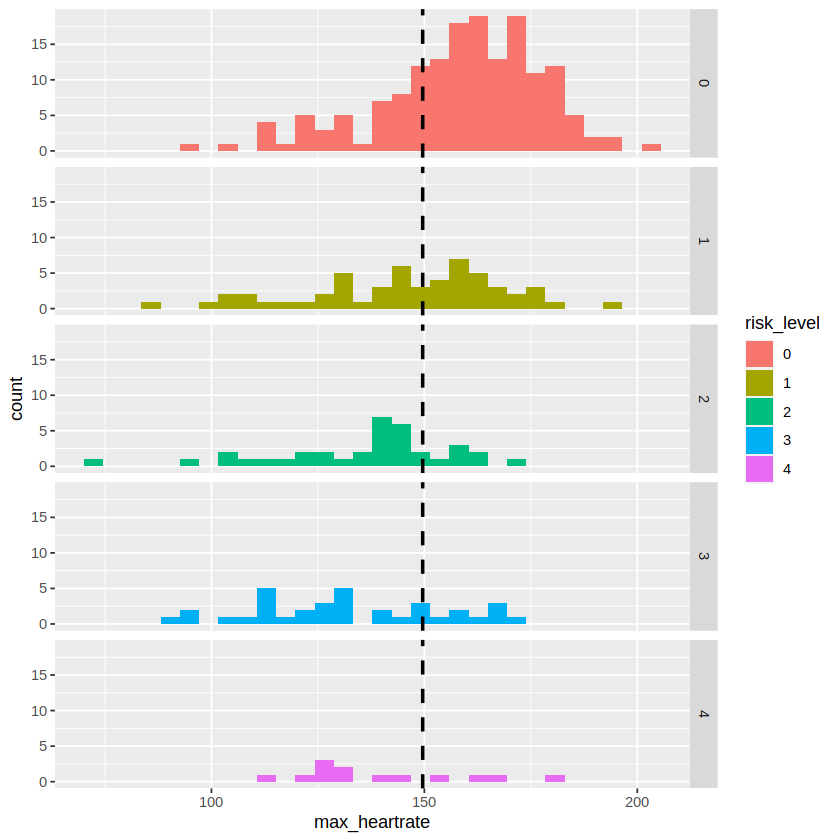

In [3]:
avg_heart_rate <- cleveland_data |>
                summarize(mean = mean(max_heartrate)) |>
                pull()

avg_heart_rate

angina_risk <- cleveland_data |>
            mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
            ggplot(aes(max_heartrate, fill = risk_level)) +
            geom_histogram() +
            facet_grid(rows = vars(risk_level)) +
            geom_vline(xintercept = avg_heart_rate, linetype = "dashed", size = 1.0)

angina_risk

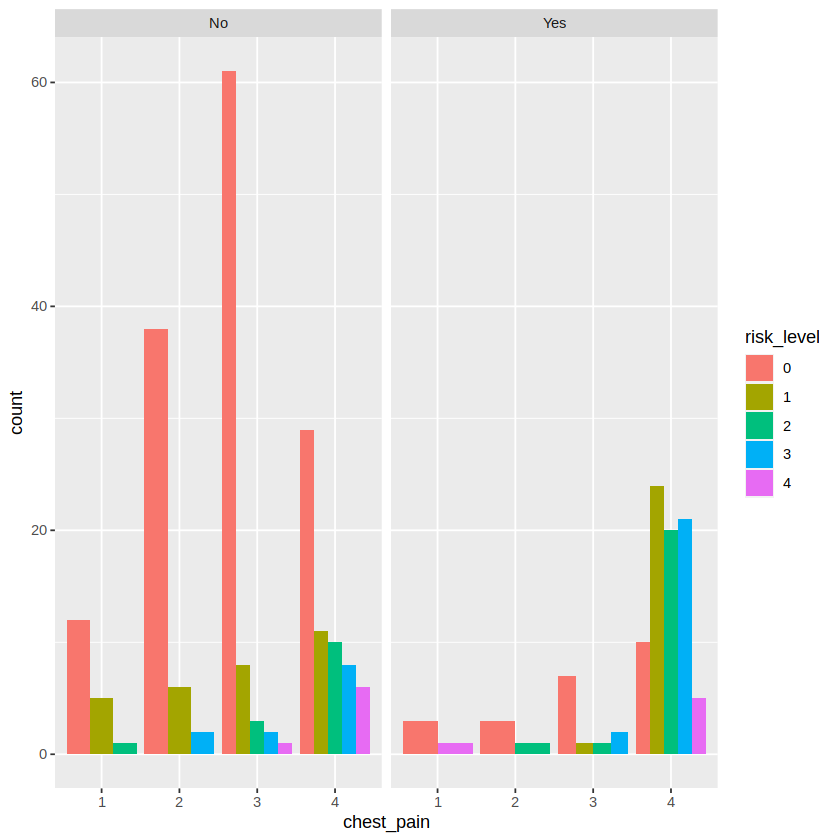

In [4]:
angina_risk_2 <- cleveland_data |>
            mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
            ggplot(aes(chest_pain, fill = risk_level)) +
            geom_bar(position="dodge") +
            facet_wrap(~exercise_induced_angina)

angina_risk_2

In [5]:
tabulated_cleveland <- cleveland_data |>
                    mutate(chest_pain = as_factor(chest_pain), risk_level = as_factor(risk_level))|>
                    group_by(chest_pain, exercise_induced_angina, risk_level) |>
                    summarize(count = n())

glimpse(tabulated_cleveland)

`summarise()` has grouped output by 'chest_pain', 'exercise_induced_angina'.
You can override using the `.groups` argument.


Rows: 29
Columns: 4
Groups: chest_pain, exercise_induced_angina [8]
$ chest_pain              <fct> 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3…
$ exercise_induced_angina <chr> "No", "No", "No", "Yes", "Yes", "No", "No", "N…
$ risk_level              <fct> 0, 1, 2, 0, 4, 0, 1, 3, 0, 2, 0, 1, 2, 3, 4, 0…
$ count                   <int> 12, 5, 1, 3, 1, 38, 6, 2, 3, 1, 61, 8, 3, 2, 1…


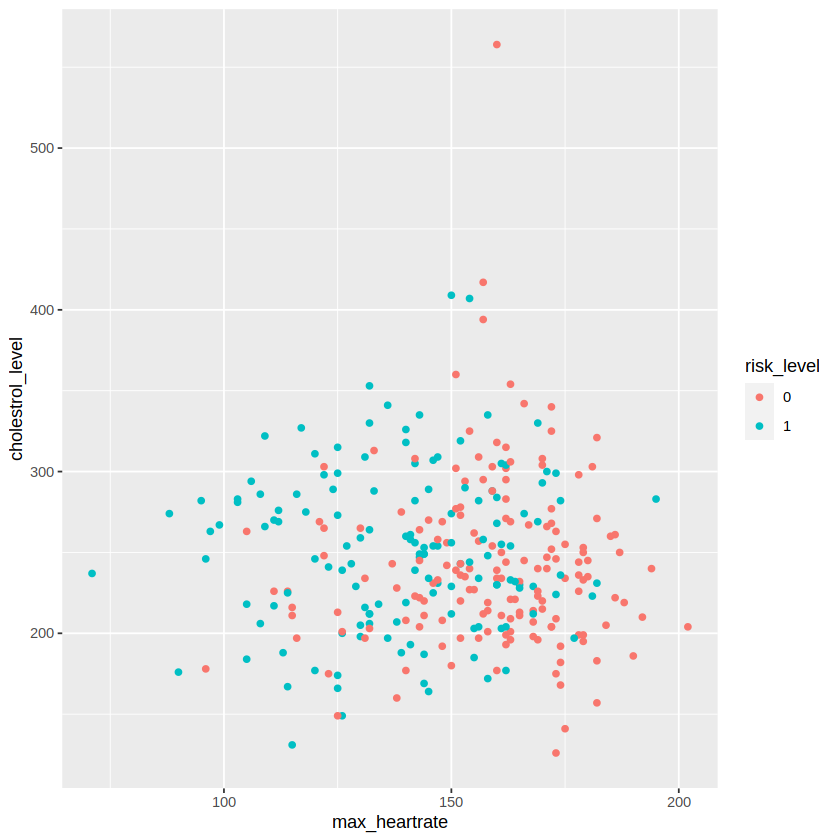

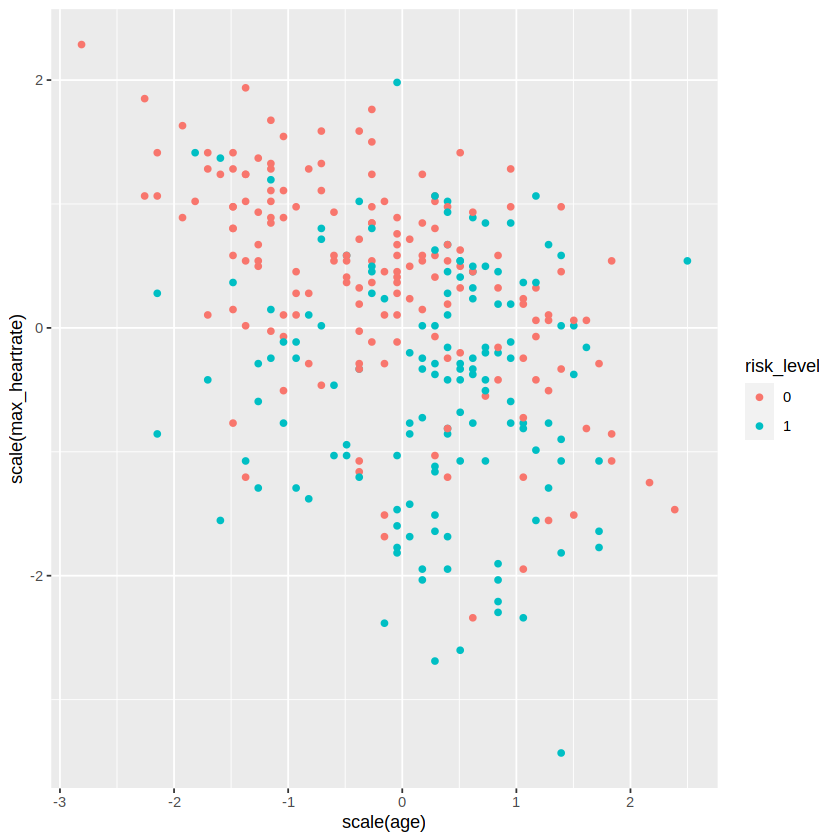

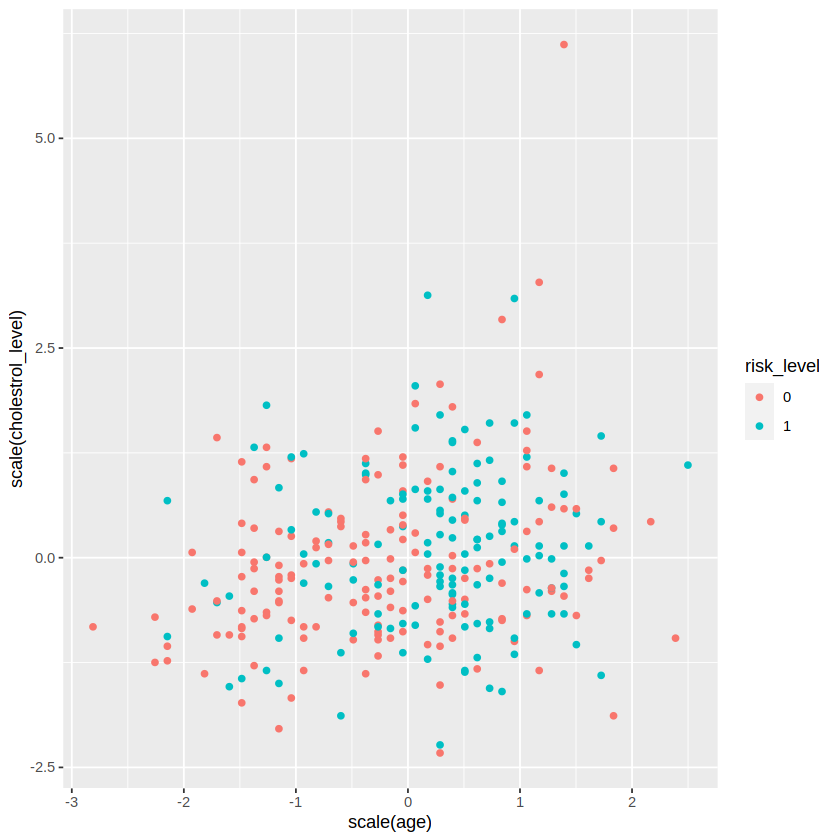

In [6]:
cleveland_data<-cleveland_data|>
                    mutate(risk_level=case_when(risk_level==0~0,risk_level==1~1,
                                         risk_level==2~1,risk_level==3~1,risk_level==4~1))

cholestrol_heartrate <- cleveland_data |>
                        mutate(risk_level = as_factor(risk_level)) |>
                        ggplot(aes(x = max_heartrate, y = cholestrol_level, color=risk_level)) +
                        geom_point()

cholestrol_heartrate

age_heartrate <- cleveland_data |>
                        mutate(risk_level = as_factor(risk_level)) |>
                        ggplot(aes(x = scale(age), y = scale(max_heartrate), color=risk_level)) +
                        geom_point()

age_heartrate

age_cholestrol <- cleveland_data |>
                        mutate(risk_level = as_factor(risk_level)) |>
                        ggplot(aes(x = scale(age), y = scale(cholestrol_level), color=risk_level)) +
                        geom_point()

age_cholestrol

In [7]:
cleveland_data <- cleveland_data |>
                select(age, max_heartrate, risk_level) |>
                mutate(risk_level = as_factor(risk_level))

cleveland_data

age,max_heartrate,risk_level
<dbl>,<dbl>,<fct>
67,108,1
67,129,1
37,187,0
⋮,⋮,⋮
57,115,1
57,174,1
38,173,0


In [8]:
set.seed(1111)

heart_split <- initial_split(cleveland_data, prop = 0.75, strata = risk_level)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train
heart_test

age,max_heartrate,risk_level
<dbl>,<dbl>,<fct>
37,187,0
41,172,0
57,163,0
⋮,⋮,⋮
59,90,1
57,115,1
57,174,1


age,max_heartrate,risk_level
<dbl>,<dbl>,<fct>
56,178,0
62,160,1
57,148,0
⋮,⋮,⋮
45,132,1
68,141,1
38,173,0


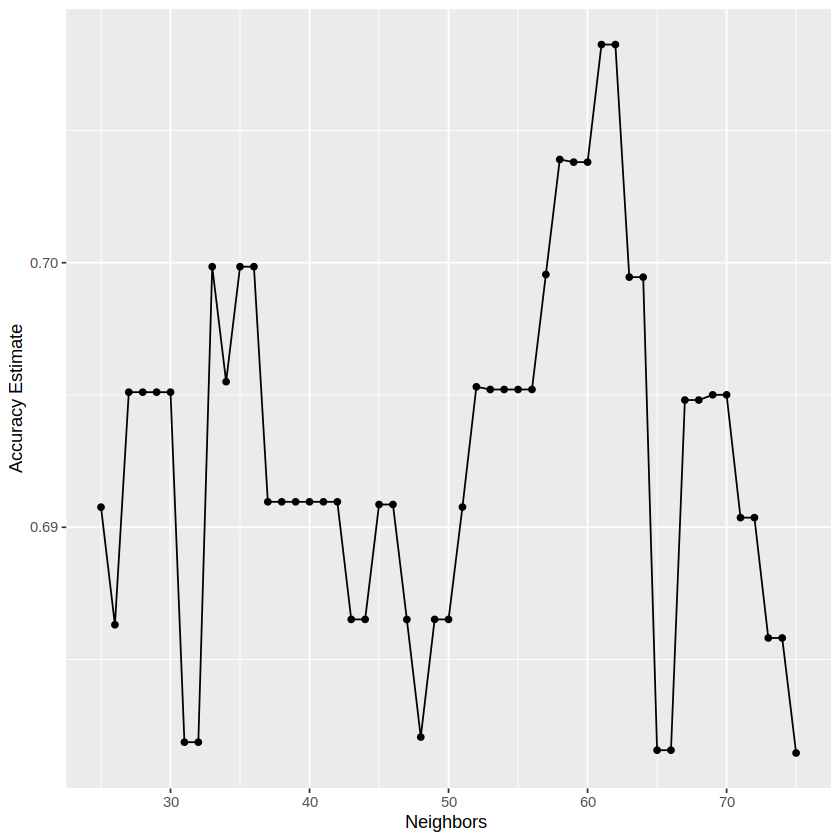

In [9]:
set.seed(2222)

heart_recipe <- recipe(risk_level ~ ., data = heart_train) |>
                step_normalize(all_predictors())

heart_vfold <- vfold_cv(heart_train, v = 5, strata = risk_level)

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 25, to = 75, by = 1))

heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_tune) |>
      tune_grid(resamples = heart_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- heart_fit |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors ", y = "Accuracy Estimate")

cross_val_plot

In [12]:
# your code here
mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 61)  |>
      set_engine("kknn") |>
      set_mode("classification")

mnist_fit <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(mnist_spec) |>
      fit(data = heart_train)

In [13]:
mnist_predictions <- predict(mnist_fit, heart_test) |>
      bind_cols(heart_test)

mnist_predictions

mnist_metrics <- mnist_predictions |>
        metrics(truth = risk_level, estimate = .pred_class) 
mnist_metrics

mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = risk_level, estimate = .pred_class) 
mnist_conf_mat

.pred_class,age,max_heartrate,risk_level
<fct>,<dbl>,<dbl>,<fct>
0,56,178,0
0,62,160,1
1,57,148,0
⋮,⋮,⋮,⋮
0,45,132,1
1,68,141,1
0,38,173,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947
kap,binary,0.2997874


          Truth
Prediction  0  1
         0 32 17
         1  9 18